## <center>Decision Trees</center>

### The Data

We will be using the same dataset through our discussions on classification with tree-methods (Decision Tree,Random Forests, and Gradient Boosted Trees) in order to compare performance metrics across these related models.

We will work with the "Palmer Penguins" dataset, as it is simple enough to help us fully understand how changing hyperparameters can change classification results.


Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

Summary:
The data folder contains two CSV files. For intro courses/examples, you probably want to use the first one (penguins_size.csv).

* penguins_size.csv: Simplified data from original penguin data sets. Contains variables:

    * species: penguin species (Chinstrap, Adélie, or Gentoo)
    * culmen_length_mm: culmen length (mm)
    * culmen_depth_mm: culmen depth (mm)
    * flipper_length_mm: flipper length (mm)
    * body_mass_g: body mass (g)
    * island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
    * sex: penguin sex

* (Not used) penguins_lter.csv: Original combined data for 3 penguin species  

Note: The culmen is "the upper ridge of a bird's beak" 

**Our goal is to create a model that can help predict a species of a penguin based on physical attributes, then we can use that model to help researchers classify penguins in the field, instead of needing an experienced biologist**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Python/Machine Learning/Supervised Learning/Tree Methods/Data Sets/penguins_size.csv")
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### EDA

#### Missing Data

Recall the purpose is to create a model for future use, so data points missing crucial information won't help in this task, especially since for future data points we will assume the research will grab the relevant feature information.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [5]:
filt = df["sex"].isnull()

df[filt]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [6]:
df.dropna(inplace=True) # Only a 2% is dropped

In [7]:
df.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In this case, the only column with null values is the sex column. The sex could be easily determined compering values like column length and depth, flipper length or body weight.

In [8]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

When grouping, a sex instance "." was found, which in fact may be an error, so before substituting the nan values, the "." must be corrected.

In [9]:
filt_dot = df["sex"] == "."

df[filt_dot]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [10]:
df.groupby(by="sex").describe().transpose()

sex                           .       FEMALE         MALE
culmen_length_mm  count     1.0   165.000000   168.000000
                  mean     44.5    42.096970    45.854762
                  std       NaN     4.903476     5.366896
                  min      44.5    32.100000    34.600000
                  25%      44.5    37.600000    40.975000
                  50%      44.5    42.800000    46.800000
                  75%      44.5    46.200000    50.325000
                  max      44.5    58.000000    59.600000
culmen_depth_mm   count     1.0   165.000000   168.000000
                  mean     15.7    16.425455    17.891071
                  std       NaN     1.795681     1.863351
                  min      15.7    13.100000    14.100000
                  25%      15.7    14.500000    16.075000
                  50%      15.7    17.000000    18.450000
                  75%      15.7    17.800000    19.250000
                  max      15.7    20.700000    21.500000
flipper_length_mm count     1.0   165.000000   168.000000
                  mean    217.0   197.363636   204.505952
                  std       NaN    12.500776    14.547876
                  min     217.0   172.000000   178.000000
                  25%     217.0   187.000000   193.000000
                  50%     217.0   193.000000   200.500000
                  75%     217.0   210.000000   219.000000
                  max     217.0   222.000000   231.000000
body_mass_g       count     1.0   165.000000   168.000000
                  mean   4875.0  3862.272727  4545.684524
                  std       NaN   666.172050   787.628884
                  min    4875.0  2700.000000  3250.000000
                  25%    4875.0  3350.000000  3900.000000
                  50%    4875.0  3650.000000  4300.000000
                  75%    4875.0  4550.000000  5312.500000
                  max    4875.0  5200.000000  6300.000000

From the data, it can be inferred that the "." instance can be more related to female than male.

In [11]:
df.at[336, "sex"] = "FEMALE"

### Visualization

<AxesSubplot:xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

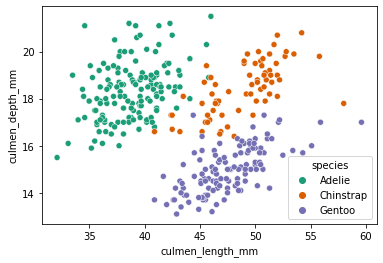

In [12]:
sns.scatterplot(x='culmen_length_mm',y='culmen_depth_mm',data=df,hue='species',palette='Dark2')

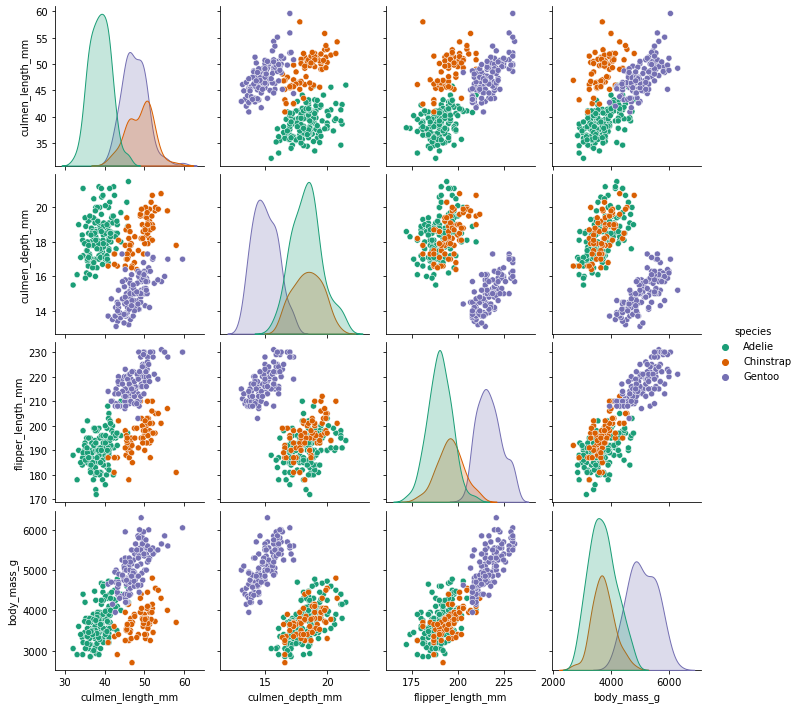

In [13]:
sns.pairplot(df,hue='species',palette='Dark2')

#### Feature Engineering

In [14]:
pd.get_dummies(df.drop('species',axis=1),drop_first=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1,1
1,39.5,17.4,186.0,3800.0,0,1,0
2,40.3,18.0,195.0,3250.0,0,1,0
4,36.7,19.3,193.0,3450.0,0,1,0
5,39.3,20.6,190.0,3650.0,0,1,1
...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0,0,0
340,46.8,14.3,215.0,4850.0,0,0,0
341,50.4,15.7,222.0,5750.0,0,0,1
342,45.2,14.8,212.0,5200.0,0,0,0


#### Train Test and Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = pd.get_dummies(df.drop('species',axis=1),drop_first=True)
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Decision Tree Classifier

Decision trees are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision. Typically, building a tree as described here and continuing until all leaves are pure leads to models that are very complex and highly overfit to the training data. The presence of pure leaves mean that a tree is 100% accurate on the training set; each data point in the training set is in a leaf that has the correct majority class.

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
model = DecisionTreeClassifier() #  Default Hyperparameters
model.fit(X_train,y_train)

base_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [20]:
confusion_matrix(y_test,base_pred)

array([[40,  1,  0],
       [ 2, 21,  0],
       [ 0,  0, 37]], dtype=int64)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


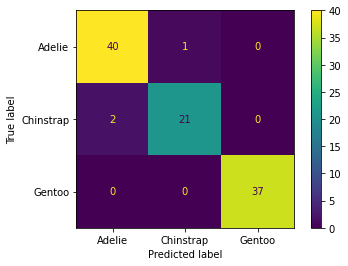

In [21]:
plot_confusion_matrix(model,X_test,y_test)

In [22]:
print(classification_report(y_test,base_pred))

              precision    recall  f1-score   support

      Adelie       0.95      0.98      0.96        41
   Chinstrap       0.95      0.91      0.93        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.97       101
   macro avg       0.97      0.96      0.97       101
weighted avg       0.97      0.97      0.97       101



#### Feature importance in trees
Instead of looking at the whole tree, which can be taxing, there are some useful properties that we can derive to summarize the workings of the tree. The most commonly used summary is feature importance, which rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.”

In [23]:
model.feature_importances_

array([0.33754639, 0.05221421, 0.542054  , 0.        , 0.0681854 ,
       0.        , 0.        ])

In [24]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance')

,Feature Importance
body_mass_g,0.000000
island_Torgersen,0.000000
sex_MALE,0.000000
culmen_depth_mm,0.052214
island_Dream,0.068185
culmen_length_mm,0.337546
flipper_length_mm,0.542054


In [25]:
sum(model.feature_importances_)

1.0000000000000002

#### Visualize the Tree

This function is fairly new, you may want to review the online docs:

Online Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

In [26]:
from sklearn.tree import plot_tree

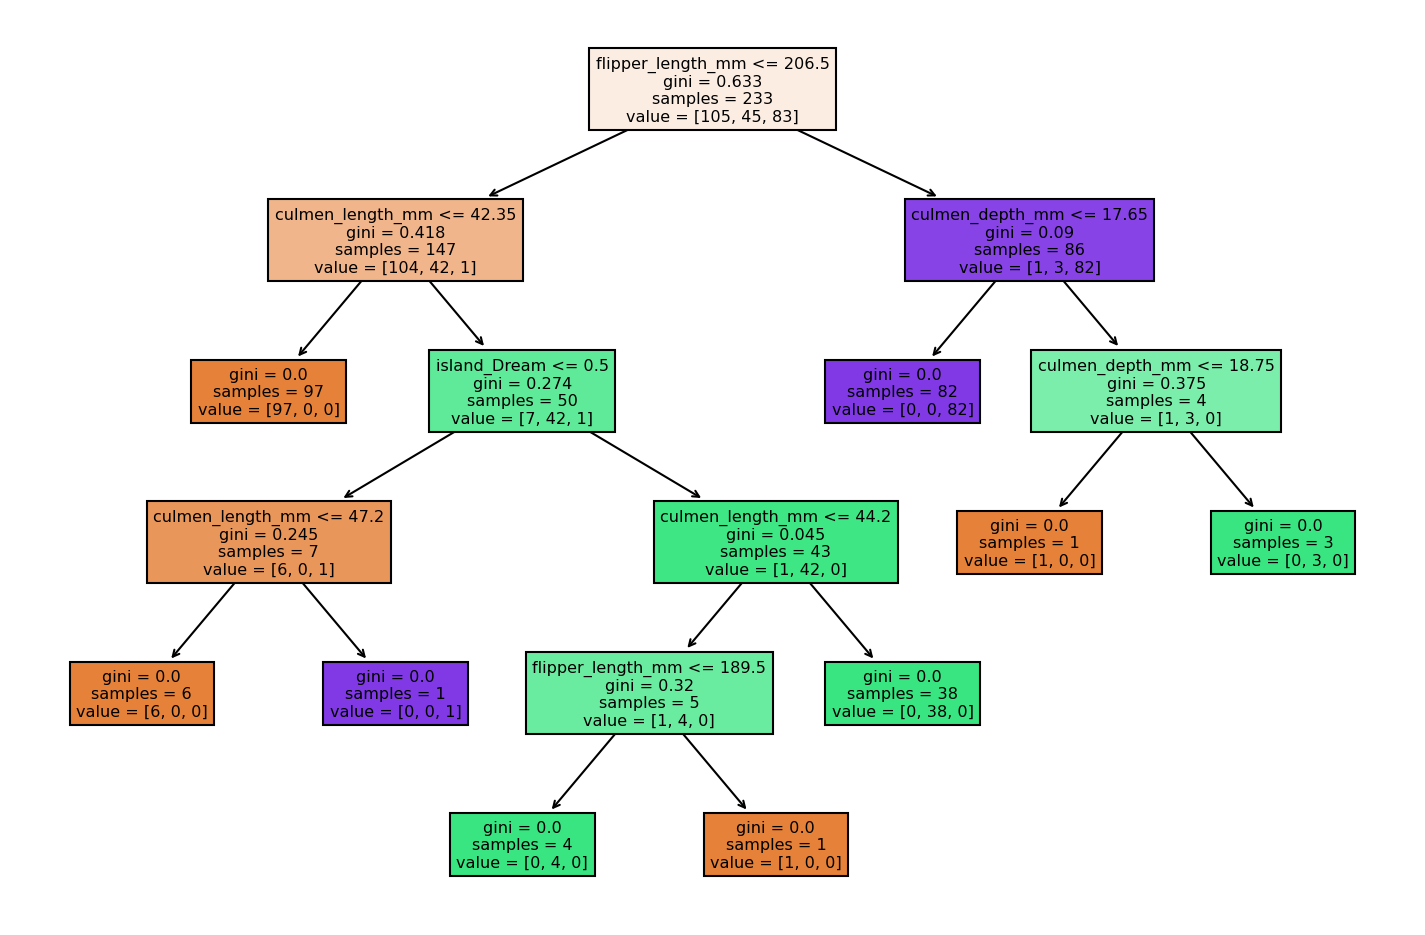

In [27]:
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model,filled=True,feature_names=X.columns);

#### Reporting Model Results

To begin experimenting with hyperparameters, let's create a function that reports back classification results and plots out the tree.

In [28]:
def report_model(model):
    model_preds = model.predict(X_test)
    print(classification_report(y_test,model_preds))
    print('\n')
    plt.figure(figsize=(12,8),dpi=150)
    plot_tree(model,filled=True,feature_names=X.columns);

#### Understanding Hyperparameters

##### 1. Max Depth

In [29]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_d

In [30]:
pruned_tree = DecisionTreeClassifier(max_depth=2) # The previous tree had 5 levels of splits
pruned_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

              precision    recall  f1-score   support

      Adelie       0.97      0.88      0.92        41
   Chinstrap       0.81      0.96      0.88        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.94       101
   macro avg       0.93      0.94      0.93       101
weighted avg       0.95      0.94      0.94       101





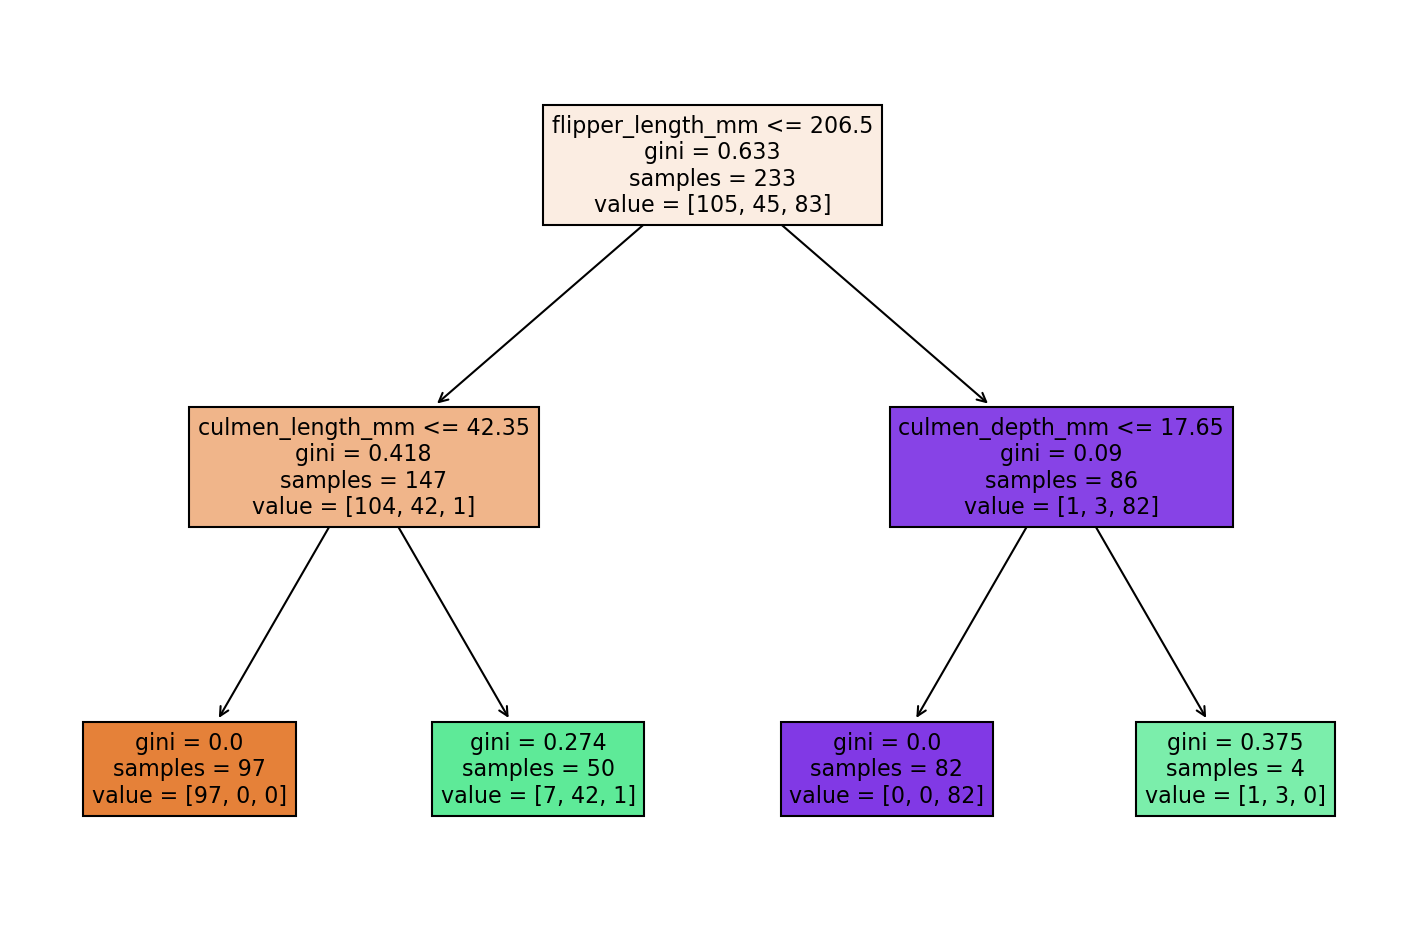

In [31]:
report_model(pruned_tree)

In this case, the tree has a lower performance, however, thos tree can be more interpretable. Avoids to overfit data.

##### 2. Max Leaf Nodes

In [32]:
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=3) # In this case, it narrows the model to have the amount of 
                                                       # leaves set. In the previous example there were 4 leaf_nodes.
pruned_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=3)

              precision    recall  f1-score   support

      Adelie       0.97      0.88      0.92        41
   Chinstrap       0.83      0.87      0.85        23
      Gentoo       0.93      1.00      0.96        37

    accuracy                           0.92       101
   macro avg       0.91      0.92      0.91       101
weighted avg       0.92      0.92      0.92       101





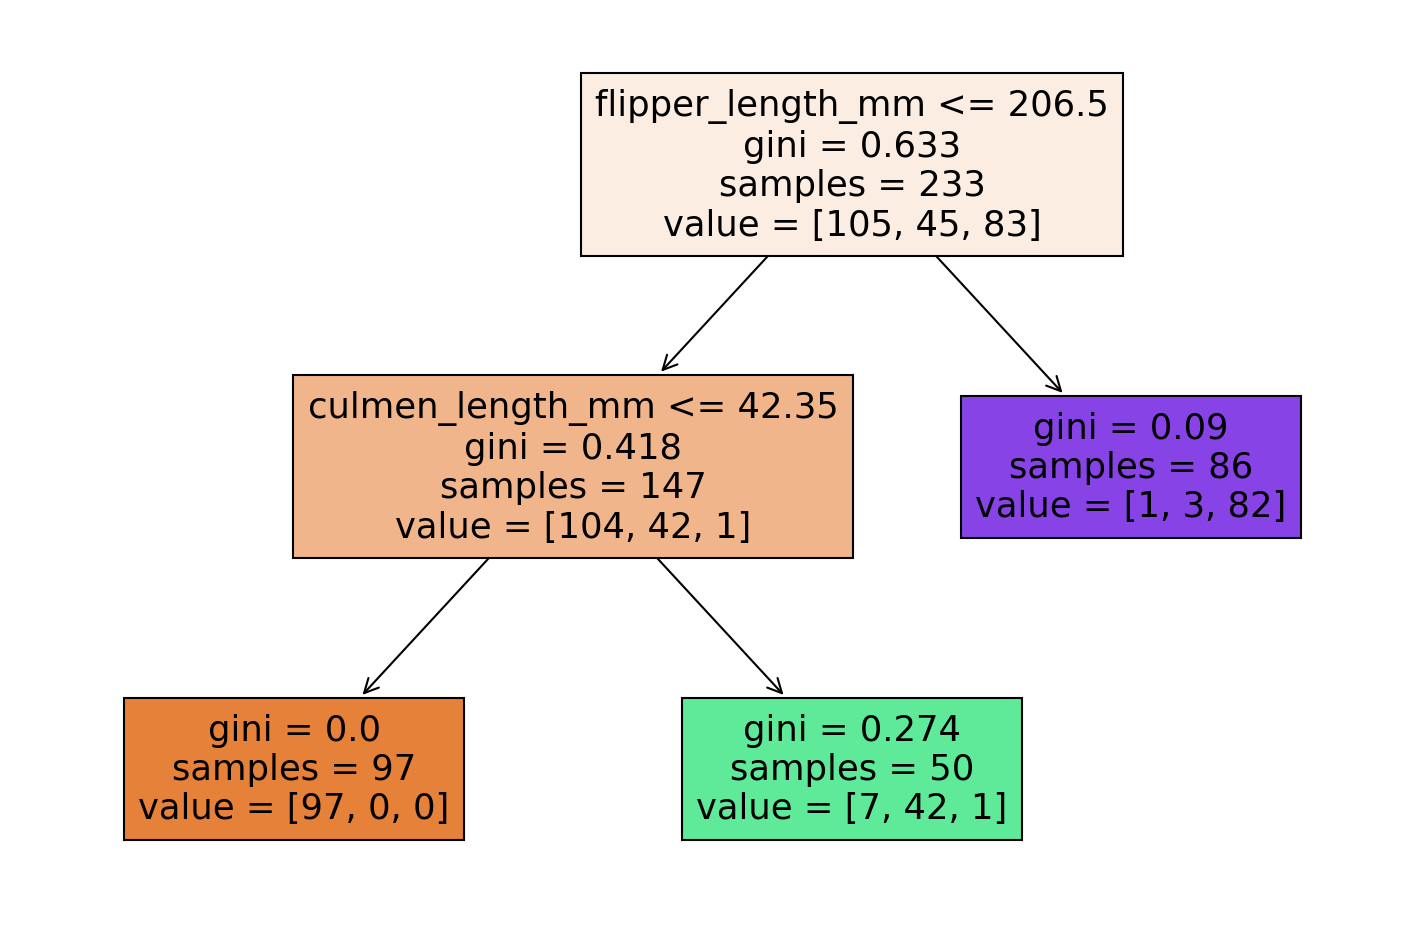

In [33]:
report_model(pruned_tree)

##### 3. Criterion

There are two criterion to chose from:
- gini impurity
- entropy

In this case, the change between these two criterion is the minimization of the objective equation used.

In [34]:
entropy_tree = DecisionTreeClassifier(criterion='entropy')
entropy_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

              precision    recall  f1-score   support

      Adelie       0.95      0.98      0.96        41
   Chinstrap       0.95      0.91      0.93        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.97       101
   macro avg       0.97      0.96      0.97       101
weighted avg       0.97      0.97      0.97       101





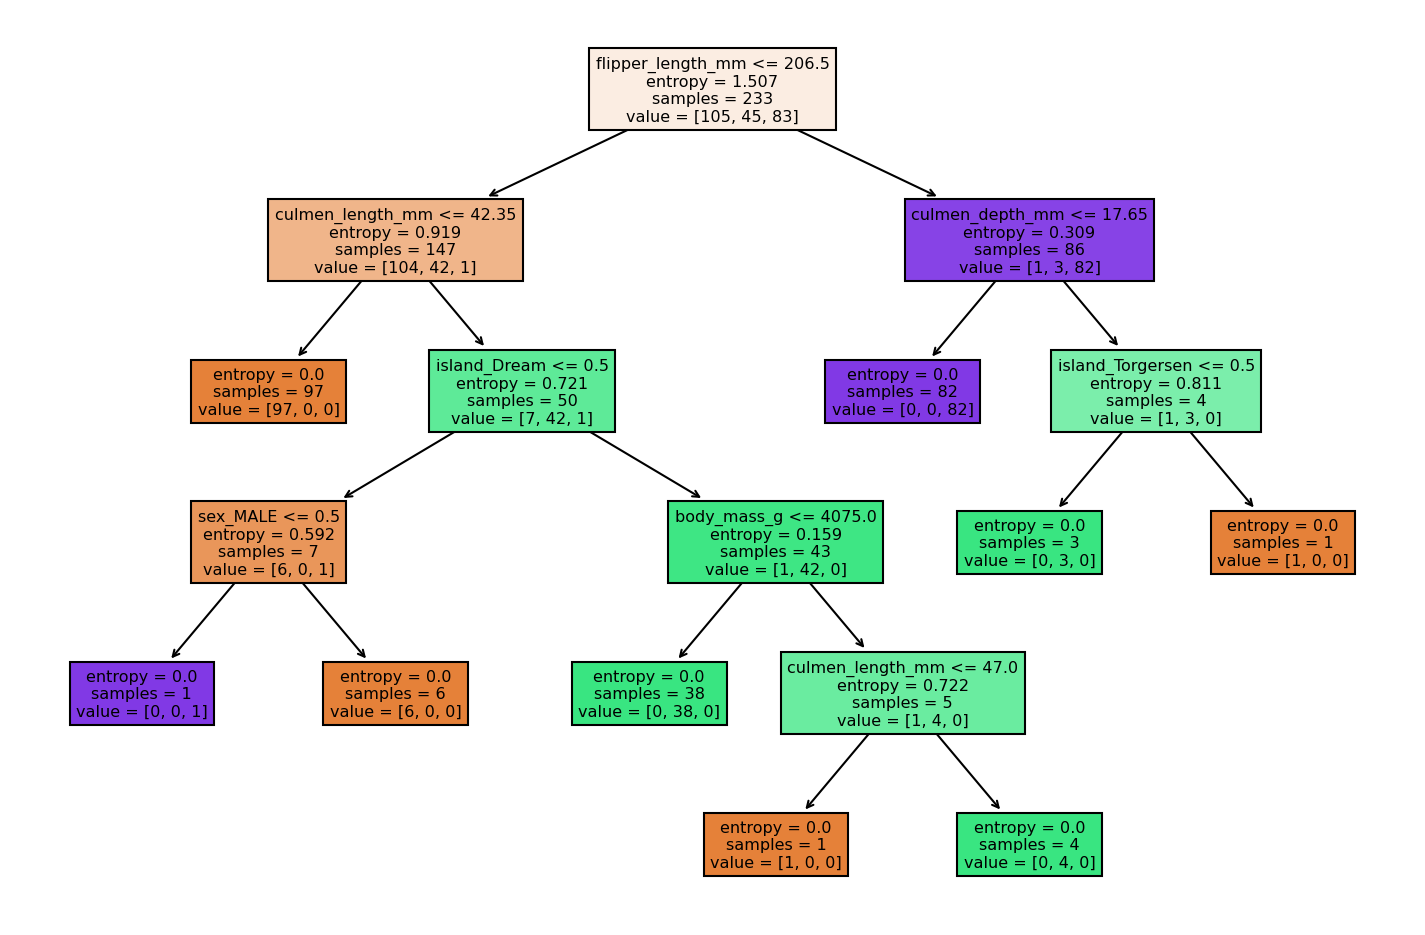

In [35]:
report_model(entropy_tree)

---

### Decision Trees Regression


 The usage and analysis of regression trees is very similar to that of classification trees. There is one particular property of using tree-based models for regression that we want to point out, DecisionTreeRegressor (and all other tree-based regression models) is not able to extrapolate, or make predictions outside of the range of the training data.

In [36]:
from sklearn.tree import DecisionTreeRegressor

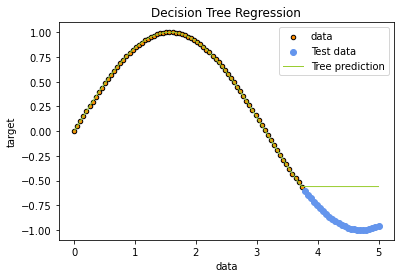

In [37]:
# Create a random dataset
x = np.linspace(0, 5, 100)
fun = lambda a: np.sin(a)

# Fit regression model
m = DecisionTreeRegressor()
X = x[:, np.newaxis]
X_train = X[:75]
y_train = fun(X_train)

# Predict values based on split
m.fit(X_train, y_train)

X_test = X[75:]
y_test = fun(X_test)


# Predict all values
pred_vals = m.predict(X)

# Plot the results
plt.figure()
plt.scatter(x, fun(x), s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(X_test, y_test, color="cornflowerblue", label="Test data")
plt.plot(X, pred_vals, color="yellowgreen", label="Tree prediction", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()